# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/A3/path/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1:
        return transforms.functional.rotate(img, 90)
    elif rot == 2:
        return transforms.functional.rotate(img, 180)
    elif rot == 3:
        return transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


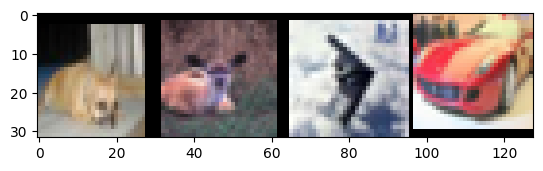

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  dog   deer  plane car  


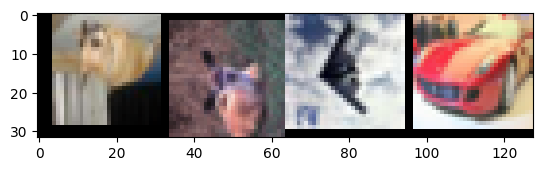

Rotation labels:  180   90    180   0    


In [3]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [4]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
                images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
                images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [8]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
#
#
#
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [38]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()
            
            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net = net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [10]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
#
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.501 acc: 33.77 time: 21.49
[1,   200] loss: 1.283 acc: 44.39 time: 8.91
[1,   300] loss: 1.199 acc: 47.32 time: 9.77
TESTING:
Accuracy of the network on the 10000 test images: 52.28 %
Average loss on the 10000 test images: 1.140
[2,   100] loss: 1.120 acc: 51.37 time: 9.01
[2,   200] loss: 1.091 acc: 53.38 time: 8.94
[2,   300] loss: 1.065 acc: 54.05 time: 8.97
TESTING:
Accuracy of the network on the 10000 test images: 55.19 %
Average loss on the 10000 test images: 1.062
[3,   100] loss: 1.043 acc: 55.52 time: 14.82
[3,   200] loss: 1.015 acc: 56.88 time: 9.08
[3,   300] loss: 1.008 acc: 57.30 time: 9.15
TESTING:
Accuracy of the network on the 10000 test images: 58.19 %
Average loss on the 10000 test images: 0.999
[4,   100] loss: 0.975 acc: 59.34 time: 9.00
[4,   200] loss: 0.968 acc: 58.93 time: 12.42
[4,   300] loss: 0.959 acc: 59.45 time: 11.02
TESTING:
Accuracy of the network on the 10000 test images: 61.80 %
Average loss on the 10000 test images: 0.914
[5,   10

[34,   100] loss: 0.538 acc: 79.11 time: 8.91
[34,   200] loss: 0.555 acc: 78.47 time: 9.09
[34,   300] loss: 0.535 acc: 79.06 time: 9.17
TESTING:
Accuracy of the network on the 10000 test images: 78.71 %
Average loss on the 10000 test images: 0.538
[35,   100] loss: 0.543 acc: 78.98 time: 14.54
[35,   200] loss: 0.530 acc: 79.21 time: 9.08
[35,   300] loss: 0.552 acc: 78.60 time: 8.98
TESTING:
Accuracy of the network on the 10000 test images: 78.50 %
Average loss on the 10000 test images: 0.542
[36,   100] loss: 0.542 acc: 79.05 time: 8.97
[36,   200] loss: 0.551 acc: 78.37 time: 9.08
[36,   300] loss: 0.535 acc: 79.21 time: 14.26
TESTING:
Accuracy of the network on the 10000 test images: 78.59 %
Average loss on the 10000 test images: 0.536
[37,   100] loss: 0.540 acc: 78.77 time: 8.90
[37,   200] loss: 0.533 acc: 79.32 time: 9.12
[37,   300] loss: 0.550 acc: 78.68 time: 9.10
TESTING:
Accuracy of the network on the 10000 test images: 78.52 %
Average loss on the 10000 test images: 0.54

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [64]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
PATH = './cifar_net_pretrained.pth'
# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=4)
net.load_state_dict(torch.load(PATH))
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
net = net.to(device)
# print(net)

In [65]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
#
#
#
#

for name, param in net.named_parameters():
    name_param = name.split('.')[0]
    if(name_param != 'layer4' and name_param != 'fc'):
        param.requires_grad = False

In [66]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [67]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.001)

In [68]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.861 acc: 29.83 time: 8.10
[1,   200] loss: 1.582 acc: 40.98 time: 8.25
[1,   300] loss: 1.504 acc: 44.88 time: 8.17
TESTING:
Accuracy of the network on the 10000 test images: 47.93 %
Average loss on the 10000 test images: 1.429
[2,   100] loss: 1.443 acc: 46.99 time: 8.44
[2,   200] loss: 1.422 acc: 48.16 time: 8.02
[2,   300] loss: 1.386 acc: 49.73 time: 8.03
TESTING:
Accuracy of the network on the 10000 test images: 51.47 %
Average loss on the 10000 test images: 1.347
[3,   100] loss: 1.381 acc: 49.88 time: 7.94
[3,   200] loss: 1.370 acc: 50.56 time: 9.54
[3,   300] loss: 1.373 acc: 50.09 time: 11.21
TESTING:
Accuracy of the network on the 10000 test images: 53.05 %
Average loss on the 10000 test images: 1.308
[4,   100] loss: 1.353 acc: 51.16 time: 7.79
[4,   200] loss: 1.353 acc: 51.23 time: 7.69
[4,   300] loss: 1.329 acc: 51.64 time: 7.86
TESTING:
Accuracy of the network on the 10000 test images: 53.53 %
Average loss on the 10000 test images: 1.310
[5,   100] 

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [69]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10, weights=None)
net = net.to(device)

In [70]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#
for name, param in net.named_parameters():
    name_param = name.split('.')[0]
    if(name_param != 'layer4' and name_param != 'fc'):
        param.requires_grad = False

In [71]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [72]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.001)

In [73]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.275 acc: 25.20 time: 8.94
[1,   200] loss: 1.937 acc: 30.35 time: 7.80
[1,   300] loss: 1.884 acc: 31.91 time: 7.73
TESTING:
Accuracy of the network on the 10000 test images: 35.30 %
Average loss on the 10000 test images: 1.782
[2,   100] loss: 1.819 acc: 34.09 time: 7.78
[2,   200] loss: 1.778 acc: 35.68 time: 7.62
[2,   300] loss: 1.766 acc: 35.28 time: 13.26
TESTING:
Accuracy of the network on the 10000 test images: 37.77 %
Average loss on the 10000 test images: 1.709
[3,   100] loss: 1.743 acc: 36.97 time: 8.18
[3,   200] loss: 1.731 acc: 37.62 time: 8.11
[3,   300] loss: 1.722 acc: 37.75 time: 8.20
TESTING:
Accuracy of the network on the 10000 test images: 39.94 %
Average loss on the 10000 test images: 1.658
[4,   100] loss: 1.720 acc: 37.66 time: 13.49
[4,   200] loss: 1.704 acc: 37.82 time: 8.30
[4,   300] loss: 1.719 acc: 38.20 time: 8.08
TESTING:
Accuracy of the network on the 10000 test images: 41.13 %
Average loss on the 10000 test images: 1.637
[5,   100]

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [74]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

PATH = './cifar_net_pretrained.pth'
# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes=4)
net.load_state_dict(torch.load(PATH))
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
net = net.to(device)

In [75]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [76]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.475 acc: 45.16 time: 8.64
[1,   200] loss: 1.204 acc: 56.53 time: 11.73
[1,   300] loss: 1.075 acc: 61.99 time: 10.69
TESTING:
Accuracy of the network on the 10000 test images: 65.47 %
Average loss on the 10000 test images: 1.002
[2,   100] loss: 0.962 acc: 66.54 time: 8.65
[2,   200] loss: 0.915 acc: 67.80 time: 8.69
[2,   300] loss: 0.898 acc: 68.51 time: 8.64
TESTING:
Accuracy of the network on the 10000 test images: 70.19 %
Average loss on the 10000 test images: 0.863
[3,   100] loss: 0.827 acc: 71.45 time: 8.56
[3,   200] loss: 0.814 acc: 71.74 time: 8.93
[3,   300] loss: 0.815 acc: 71.78 time: 8.73
TESTING:
Accuracy of the network on the 10000 test images: 74.44 %
Average loss on the 10000 test images: 0.749
[4,   100] loss: 0.744 acc: 74.43 time: 9.41
[4,   200] loss: 0.743 acc: 74.62 time: 14.40
[4,   300] loss: 0.746 acc: 74.57 time: 9.04
TESTING:
Accuracy of the network on the 10000 test images: 75.34 %
Average loss on the 10000 test images: 0.730
[5,   100

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [77]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net = resnet18(num_classes=10, weights=None)
net = net.to(device)

In [78]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [79]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.220 acc: 24.91 time: 8.58
[1,   200] loss: 1.839 acc: 33.33 time: 13.34
[1,   300] loss: 1.679 acc: 37.99 time: 9.09
TESTING:
Accuracy of the network on the 10000 test images: 43.67 %
Average loss on the 10000 test images: 1.554
[2,   100] loss: 1.521 acc: 43.67 time: 8.65
[2,   200] loss: 1.416 acc: 47.96 time: 8.73
[2,   300] loss: 1.404 acc: 48.66 time: 8.73
TESTING:
Accuracy of the network on the 10000 test images: 53.93 %
Average loss on the 10000 test images: 1.379
[3,   100] loss: 1.256 acc: 54.75 time: 8.88
[3,   200] loss: 1.194 acc: 56.64 time: 8.97
[3,   300] loss: 1.162 acc: 58.30 time: 8.91
TESTING:
Accuracy of the network on the 10000 test images: 61.93 %
Average loss on the 10000 test images: 1.071
[4,   100] loss: 1.093 acc: 60.61 time: 13.19
[4,   200] loss: 1.050 acc: 62.95 time: 11.27
[4,   300] loss: 1.024 acc: 63.95 time: 8.90
TESTING:
Accuracy of the network on the 10000 test images: 64.95 %
Average loss on the 10000 test images: 0.994
[5,   100